### AutoEncodeur

Dans ce notebook, je présente comment on passe d'un autoencodeur à un variationnel autoencodeur.

https://arxiv.org/pdf/1312.6114.pdf

https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/


In [1]:
import os
import torch
torch.manual_seed(42)
import numpy as np

import torchvision.datasets as dst
import torchvision

from torch.utils.data import DataLoader

import torch.nn as nn

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()




In [2]:
#Convert image to tensor
transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [3]:
#Télécharger les données

MNIST=dst.MNIST(root='./data',download=True, transform=transform)

In [4]:
#Charger les données
data_load=DataLoader(MNIST,batch_size=128,num_workers=4)

In [5]:
def imshow(image):
    '''Cette fonction convertit un tensor en image et le montre
    inputs:
    _________________________
    
    image: tensor object
    
    
    returns:
    _______________________________
    
    plot of the images
    
    '''
    np_image=np.transpose(image.numpy(),(1,2,0))
    
    np_image=np.clip(np_image,0,1)
    plt.imshow(np_image)
    

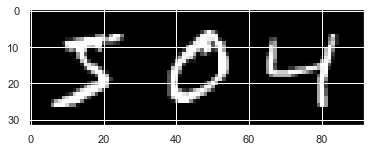

In [6]:
data_iter=iter(data_load)
img,_=next(data_iter)

imshow(torchvision.utils.make_grid(img[:3]))


In [7]:
def add_noise(img):
    '''
    inputs: image
    _________________________
    
    return: noising image
    
    '''
    
    noise=torch.randn_like(img)*0.2
    return img+noise

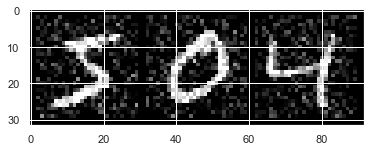

In [8]:
images=add_noise(img)

imshow(torchvision.utils.make_grid(images[:3]))

In [9]:
img.view(img.size(0),-1).size()

torch.Size([128, 784])

In [10]:
img.size()

torch.Size([128, 1, 28, 28])

In [11]:
class Ae(nn.Module):
    def __init__(self):
        super (Ae,self).__init__()
        self.encoder=nn.Sequential(
                            nn.Linear(in_features=28*28,out_features=256),
                            nn.ReLU(True),
                            nn.Linear(in_features=256,out_features=64),
                            nn.ReLU(True)
                                )
            
        self.decoder=nn.Sequential(
                        nn.Linear(in_features=64,out_features=256),
                        nn.ReLU(True),
                        nn.Linear(in_features=256,out_features=28*28),
                        nn.Sigmoid())
            
            
            
            
    def forward(self,x):
            x=self.encoder(x)
            x=self.decoder(x)
            return x
            
            

In [12]:
def to_image(img):
    return img.view(img.size(0),1,28,28)

In [13]:
lr=0.01
epochs=100

model=Ae()
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


for epoch in range(epochs):
    for i, data in enumerate(data_load):
        img,_=data
        img=img.view(img.size(0),-1)
        
        noise_img=add_noise(img)
        output=model(noise_img)
        
        loss=criterion(output,img)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
        
        
    if epoch % 10 == 0:
        print(f'epoch[{epoch+1}/{epochs}], loss:{loss.item()}')
            

print('Finished Training')

epoch[1/100], loss:0.136943519115448
epoch[11/100], loss:0.11138252913951874
epoch[21/100], loss:0.11064396053552628
epoch[31/100], loss:0.1086827889084816
epoch[41/100], loss:0.11159538477659225
epoch[51/100], loss:0.1091216579079628
epoch[61/100], loss:0.11001215875148773
epoch[71/100], loss:0.10947851836681366
epoch[81/100], loss:0.10818161815404892
epoch[91/100], loss:0.11023636907339096
Finished Training


Text(0.5, 1.0, 'True image')

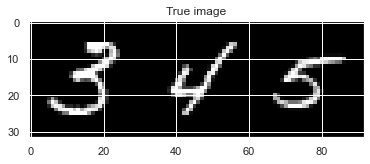

In [14]:
imshow(torchvision.utils.make_grid(to_image(img.detach())[:3]))
plt.title('True image')

Text(0.5, 1.0, 'Corrupted image')

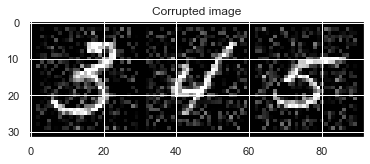

In [15]:
imshow(torchvision.utils.make_grid(to_image(noise_img.detach())[:3]))
plt.title('Corrupted image')

Text(0.5, 1.0, 'AutoEncodeur Denoising')

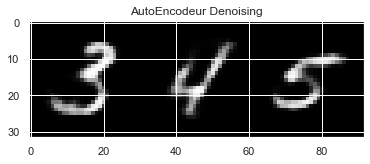

In [16]:
imshow(torchvision.utils.make_grid(to_image(output.detach())[:3]))
plt.title('AutoEncodeur Denoising')

### Variational AutoEncodeur

In [90]:
class VAe(nn.Module):
    ''' Simple variational AutoEncodeur'''
    def __init__(self):
        super (VAe,self).__init__()
        self.encoder=nn.Sequential(
                            nn.Linear(in_features=28*28,out_features=256),
                            nn.ReLU(True),
                            nn.Linear(in_features=256,out_features=64),
                            #nn.ReLU(True)
                                )
            
        self.decoder=nn.Sequential(
                        nn.Linear(in_features=32,out_features=256),
                        nn.ReLU(True),
                        nn.Linear(in_features=256,out_features=28*28),
                        nn.Sigmoid())
        
    def reprametrise(self, mu,log_var):  #Reparametrisation trick
            sigma=torch.exp(0.5*log_var) # mu and log_var form latent space
            eps=torch.randn_like(sigma)
            return mu+ eps*sigma
            
            
            
            
    def forward(self,x):
            x=self.encoder(x)
            x=x.view(-1,2,32)
            
            mu, log_var=x[:,0,:], x[:,1,:]
            z=self.reprametrise(mu,log_var)
            
            r=self.decoder(z)
            return r,mu,log_var
            
            

In [58]:
lr=0.0001


model=VAe()
criterion=nn.BCELoss(reduction='sum')
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


In [59]:
def final_loss(criterion,mu,log_var):
    kl=-0.5*torch.sum(1+log_var-mu.pow(2)-torch.exp(log_var))
    
    return criterion+kl

In [65]:
epochs=50
for epoch in range(epochs):
    for i, data in enumerate(data_load):
        img,_=data
        img=img.view(img.size(0),-1)
        
        output,mu,log_var=model(img)

        
        loss=final_loss(criterion(output,img),mu=mu,log_var=log_var)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
        
          
    if epoch % 5 == 0:
        print(f'epoch[{epoch+1}/{epochs}], loss:{loss.item()}')
            

print('Finished Training')

epoch[1/50], loss:10931.509765625
epoch[6/50], loss:10785.365234375
epoch[11/50], loss:10786.7490234375
epoch[16/50], loss:10734.3193359375
epoch[21/50], loss:10698.15234375
epoch[26/50], loss:10701.94140625
epoch[31/50], loss:10648.2216796875
epoch[36/50], loss:10554.4501953125
epoch[41/50], loss:10606.21875
epoch[46/50], loss:10581.6162109375
Finished Training


In [69]:
data_iter=iter(data_load)
img,_=next(data_iter)

In [70]:
img.size()

torch.Size([128, 1, 28, 28])

In [71]:
model=model.eval()
with torch.no_grad():
    recons,_,_=model(img.view(img.size(0),-1))

In [72]:
A=torch.cat((img.view(128, 1, 28, 28)[:8], 
                                  recons.view(128, 1, 28, 28)[:8]))

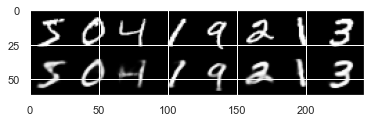

In [73]:
imshow(torchvision.utils.make_grid(A))

### generating images

In [74]:
s=np.random.standard_normal(size=(3,128,32))
with torch.no_grad():
    g1=model.decoder(torch.tensor(s[0]).view(128,32).float())
    g2=model.decoder(torch.tensor(s[1]).view(128,32).float())
    g3=model.decoder(torch.tensor(s[2]).view(128,32).float())
   


In [75]:
B=torch.cat((g1.view(128, 1, 28, 28)[:8], 
                                  g2.view(128, 1, 28, 28)[:8],g3.view(128, 1, 28, 28)[:8] ))

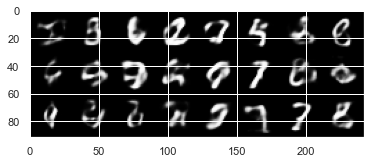

In [76]:
imshow(torchvision.utils.make_grid(B))

pt